# Lab 1: Independent Component Analysis

### Machine Learning 2 (2017/2018)

* The lab exercises should be made in groups of two people.
* The deadline is Thursday, April 19, 23:59.
* Assignment should be submitted through BlackBoard! Make sure to include your and your teammates' names with the submission.
* Attach the .IPYNB (IPython Notebook) file containing your code and answers. Naming of the file should be "studentid1\_studentid2\_lab#", for example, the attached file should be "12345\_12346\_lab1.ipynb". Only use underscores ("\_") to connect ids, otherwise the files cannot be parsed.

Notes on implementation:

* You should write your code and answers in an IPython Notebook: http://ipython.org/notebook.html. If you have problems, please ask.
* Use __one cell__ for code and markdown answers only!
    * Put all code in the cell with the ```# YOUR CODE HERE``` comment and overwrite the ```raise NotImplementedError()``` line.
    * For theoretical questions, put your solution using LaTeX style formatting in the YOUR ANSWER HERE cell.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* Large parts of you notebook will be graded automatically. Therefore it is important that your notebook can be run completely without errors and within a reasonable time limit. To test your notebook before submission, select Kernel -> Restart \& Run All.

### Literature
In this assignment, we will implement the Independent Component Analysis algorithm as described in chapter 34 of David MacKay's book "Information Theory, Inference, and Learning Algorithms", which is freely available here:
http://www.inference.phy.cam.ac.uk/mackay/itila/book.html

Read the ICA chapter carefuly before you continue!

### Notation

$\mathbf{X}$ is the $M \times T$ data matrix, containing $M$ measurements at $T$ time steps.

$\mathbf{S}$ is the $S \times T$ source matrix, containing $S$ source signal values at $T$ time steps. We will assume $S = M$.

$\mathbf{A}$ is the mixing matrix. We have $\mathbf{X} = \mathbf{A S}$.

$\mathbf{W}$ is the matrix we aim to learn. It is the inverse of $\mathbf{A}$, up to indeterminacies (scaling and permutation of sources).

$\phi$ is an elementwise non-linearity or activation function, typically applied to elements of $\mathbf{W X}$.

### Code
In the following assignments, you can make use of the signal generators listed below.



In [1]:
%pylab inline
import sys
assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed"

# Signal generators
def sawtooth(x, period=0.2, amp=1.0, phase=0.):
    return (((x / period - phase - 0.5) % 1) - 0.5) * 2 * amp

def sine_wave(x, period=0.2, amp=1.0, phase=0.):
    return np.sin((x / period - phase) * 2 * np.pi) * amp

def square_wave(x, period=0.2, amp=1.0, phase=0.):
    return ((np.floor(2 * x / period - 2 * phase - 1) % 2 == 0).astype(float) - 0.5) * 2 * amp

def triangle_wave(x, period=0.2, amp=1.0, phase=0.):
    return (sawtooth(x, period, 1., phase) * square_wave(x, period, 1., phase) + 0.5) * 2 * amp

def random_nonsingular_matrix(d=2):
    """
    Generates a random nonsingular (invertible) matrix of shape d*d
    """
    epsilon = 0.1
    A = np.random.rand(d, d)
    while abs(np.linalg.det(A)) < epsilon:
        A = np.random.rand(d, d)
    return A

def plot_signals(X, title="Signals"):
    """
    Plot the signals contained in the rows of X.
    """
    figure()
    
    for i in range(X.shape[0]):
        ax = plt.subplot(X.shape[0], 1, i + 1)
        plot(X[i, :])
        ax.set_xticks([])
        ax.set_yticks([])
    plt.suptitle(title)

Populating the interactive namespace from numpy and matplotlib


The following code generates some toy data to work with.

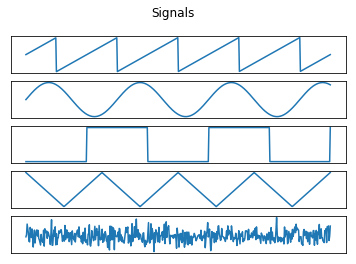

In [2]:
# Generate data
num_sources = 5
signal_length = 500
t = linspace(0, 1, signal_length)
S = np.c_[sawtooth(t), sine_wave(t, 0.3), square_wave(t, 0.4), triangle_wave(t, 0.25), np.random.randn(t.size)].T
plot_signals(S)

### 1.1 Make mixtures (5 points)
Write a function `make_mixtures(S, A)' that takes a matrix of source signals $\mathbf{S}$ and a mixing matrix $\mathbf{A}$, and generates mixed signals $\mathbf{X}$.

In [3]:
### 1.1 Make mixtures
def make_mixtures(S, A):
    return A.dot(S)

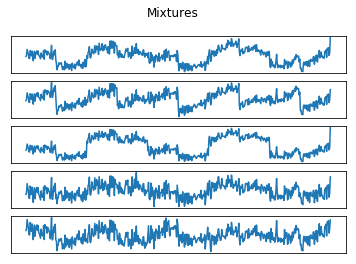

In [4]:
### Test your function
np.random.seed(42)
A = random_nonsingular_matrix(d=S.shape[0])
X = make_mixtures(S, A)
plot_signals(X, "Mixtures")

assert X.shape == (num_sources, signal_length), "The shape of your mixed signals is incorrect"


### 1.2 Histogram (5 points)
Write a function `plot_histograms(X)` that takes a data-matrix $\mathbf{X}$ and plots one histogram for each signal (row) in $\mathbf{X}$. You can use the `np.histogram()` (followed by `plot`) or `plt.hist()` function. 

Plot histograms of the sources and the measurements.

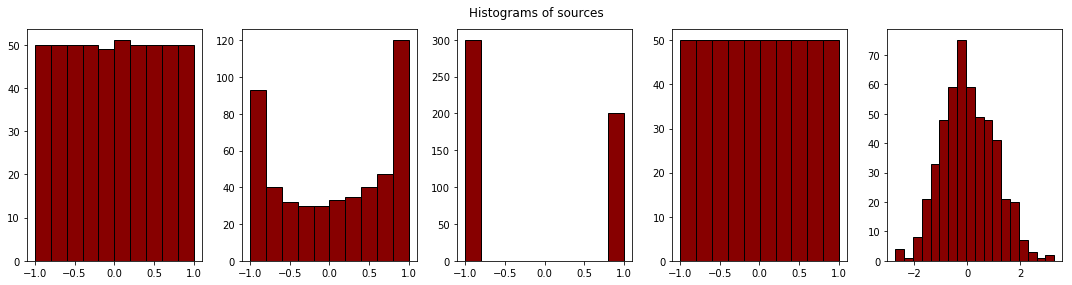

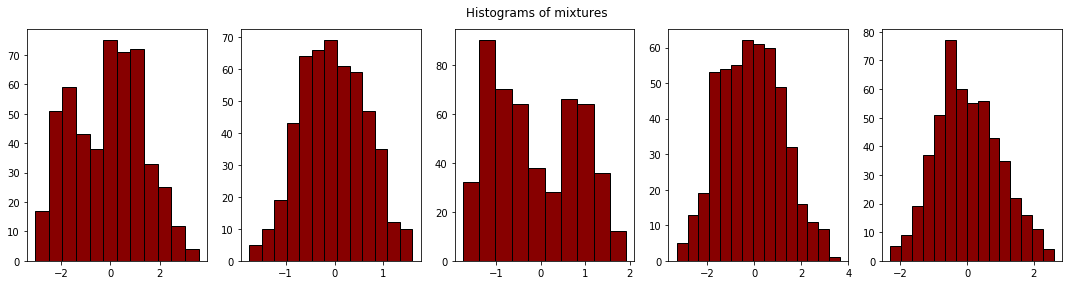

In [5]:
### 1.2 Histogram
def plot_histogram(X, title='Histograms'):
    """
    Plot histograms for the rows in X.
    """
    
    fig = figure(figsize=(15,4))
    fig.suptitle(title)
    
    for k in range(X.shape[0]):
        ax = plt.subplot(1, X.shape[0], k + 1)
        plt.hist(X[k, :], color='#870000', edgecolor='k', bins='auto')
        
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    
plot_histogram(S, 'Histograms of sources')
plot_histogram(X, 'Histograms of mixtures')

Which of these distributions (sources or measurements) tend to look more like Gaussians? Can you think of an explanation for this phenomenon? Why is this important for ICA?

The first 4 source signals are definitely not Gaussian; the only source signal which looks like a Gaussian distribution is the random wave, which, being drawn with the function $\verb|np.random.randn|$, is actually sampled from a Gaussian distribution.

Almost all mixtures (except the 3rd one) tend to look like Gaussian distributions. One reason behind this is that one of the mixture's components is a Gaussian distribution (the random wave). We can also motivate this behaviour using the Central Limit Theorem, which states that when summing up independent random variables, the resulting distribution tends towards a normal distribution.

In ICA, it is important to avoid distributions which are Gaussians, because we assume that the source signals are non-Gaussian, while also independent of each other. Using Gaussian sources leads to impossibility of recovering the original sources.

### 1.3 Implicit priors (20 points)
As explained in MacKay's book, an activation function $\phi$ used in the ICA learning algorithm corresponds to a prior distribution over sources. Specifically, $\phi(a) = \frac{d}{da} \ln p(a)$. For each of the following activation functions, *derive* the source distribution they correspond to.
$$\phi_0(a) = -\tanh(a)$$
$$\phi_1(a) = -a + \tanh(a)$$
$$\phi_2(a) = -a^3$$
$$\phi_3(a) = -\frac{6a}{a^2 + 5}$$

Give your answer without the normalizing constant, so an answer of the form $p(a) \propto \verb+[answer]+$ is ok.

$$p_0(a) \propto e^{\int \phi_0(a)} = e^{\int -\tanh(a)} = e^{-\ln{\cosh(a)}} = \cosh(a)^{-1}$$

---
$$p_1(a) \propto e^{\int \phi_1(a)} = e^{\int -a + \tanh(a)} = e^{-\frac{a^2}{2} + \ln{\cosh(a)}} = e^{-\frac{a^2}{2}} \cdot \cosh(a)$$

---
$$p_2(a) \propto e^{\int \phi_2(a)} = e^{\int -a^3} = e^{-\frac{a^4}{4}}$$

---
$$p_3(a) \propto e^{\int \phi_3(a)} = e^{\int -\frac{6a}{a^2 + 5}} = e^{-3 \ln{(a^2 + 5)}} = e^{\ln{(a^2 + 5)}^{-3}} = (a^2 + 5)^{-3}$$

In [6]:
def phi_0(a):
    return -np.tanh(a)

def p_0(a):
    return np.power(np.cosh(a), -1)

In [7]:
def phi_1(a):
    return -a + np.tanh(a)

def p_1(a):
    return np.exp(- np.power(a, 2) / 2) * np.cosh(a)

In [8]:
def phi_2(a):
    return -a**3

def p_2(a):
    return np.exp(- np.power(a, 4) / 4)

In [9]:
def phi_3(a):
    return -6*a / (np.power(a, 2) + 5)

def p_3(a):
    return np.power(np.power(a, 2) + 5 , -3)

In [10]:
activation_functions = [phi_0, phi_1, phi_2, phi_3]
priors = [p_0, p_1, p_2, p_3]

a = np.linspace(-5, 5, 1000)
for prior in priors:
    assert prior(a).shape == (1000, ), "Wrong output shape"


Plot the activation functions and the corresponding prior distributions, from $a = -5$ to $5$ (hint: use the lists defined in the cell above). Compare the shape of the priors to the histogram you plotted in the last question.

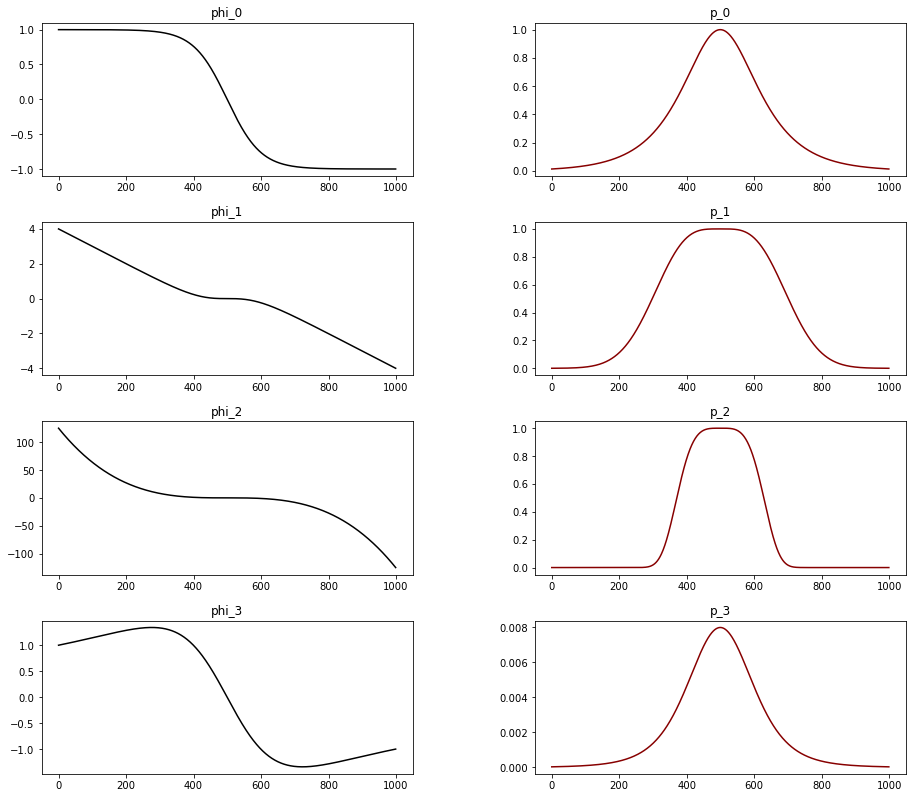

In [11]:
### 1.3 Implicit priors (continued)
a = np.linspace(-5, 5, 1000)

idx = 1
fig = figure(figsize=(12,12))

for i in range(len(priors)):
    ax = plt.subplot(5, 2, idx)
    ax.set_title(activation_functions[i].__name__)
    ax.plot(activation_functions[i](a), color='black')
    idx += 1
    
    ax = plt.subplot(5, 2, idx)
    ax.set_title(priors[i].__name__)
    ax.plot(priors[i](a), color='#870000')
    idx += 1

fig.subplots_adjust(top=1.2, bottom=0.1, left=0, right=1, hspace=0.3, wspace=0.33)

Comparing the historgrams of priors with the histograms of signals, we see the highest resemblance between priors $p_0$, $p_3$ and the random wave, which is normally distributed.

$p_1$ and $p_2$ present a flatter top than the other priors, which correspond well to signals sawtooth, sine wave and triangle wave (histograms 1, 2 and 3).

### 1.4 Whitening (15 points)
Some ICA algorithms can only learn from whitened data. Write a method `whiten(X)` that takes a $M \times T$ data matrix $\mathbf{X}$ (where $M$ is the dimensionality and $T$ the number of examples) and returns a whitened matrix. If you forgot what whitening is or how to compute it, various good sources are available online, such as http://courses.media.mit.edu/2010fall/mas622j/whiten.pdf. Your function should also center the data before whitening.

In [12]:
### 1.4 Whitening
def whiten(X):
    """
    Whitening process of matrix X
    """
    # center data
    X = X - np.mean(X, axis=1)[:, np.newaxis]
    
    # compute covariance matrix Sigma = X * X^T
    Sigma = np.cov(X)
    
    # eigenvalue decomposition to get eigenvalues and eigenvectors of covariance matrix
    d, Phi = np.linalg.eig(Sigma)
    
    # construct matrix of eigenvalues and whitening matrix
    D = np.diag(np.power(d, -0.5))
    W = Phi.dot(D).dot(Phi.T)
    
    # whiten data, Xw = W^T * X
    X_whitened = W.T.dot(X)
    
    return X_whitened

In [13]:
### Test your function
Xw = whiten(X)
assert Xw.shape == (num_sources, signal_length), "The shape of your mixed signals is incorrect"


### 1.5 Interpret results of whitening (10 points)
Make 3 figures, one for the sources, one for measurements and one for the whitened measurements. In each figure, make $5 \times 5$ subplots with scatter plots for each pair of signals. Each axis represents a signal and each time-instance is plotted as a dot in this space. You can use the `plt.scatter()` function. Describe what you see.

Now compute and visualize the covariance matrix of the sources, the measurements and the whitened measurements. You can visualize each covariance matrix using this code:
```python
# Dummy covariance matrix C;
C = np.eye(5)  
ax = imshow(C, cmap='gray', interpolation='nearest')
```

KeyboardInterrupt: 

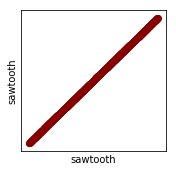

In [14]:
### 1.5 Interpret results of whitening
def plot_signal_pairs(data, title="Measurements", axis=["a"]):
    k = 1

    fig = figure(figsize=(15,15))
    
    for i in range(data.shape[0]):
        for j in range(data.shape[0]):
            signal_1 = data[i,:]
            signal_2 = data[j,:]

            ax = plt.subplot(5, 5, k)
            plt.scatter(signal_1, signal_2, color='#870000')
            ax.set_xlabel(axis[i])
            ax.set_ylabel(axis[j])
            ax.set_xticks([])
            ax.set_yticks([])

            k = k + 1

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.suptitle(title, size=16)
    
def plot_covariance_matrix(M, titles):
    fig = figure(figsize=(12,12))
    
    for i in range(len(M)):
        mat = M[i]
        title = titles[i]
        
        Cov = np.cov(mat)
        ax = plt.subplot(1, len(M), i + 1)
        imshow(Cov, cmap='gray', interpolation='nearest')
        ax.set_xticks([])
        ax.set_yticks([])
        plt.title("Covariance " + title)
    
plot_signal_pairs(S, "Sources", ["sawtooth", "sine_wave", "square_wave", "triangle_wave", "random_wave"])
plot_signal_pairs(X, "Measurements", ["Mix_1", "Mix_2", "Mix_3", "Mix_4", "Mix_5"])
plot_signal_pairs(Xw, "Whitened data", ["WMix_1", "WMix_2", "WMix_3", "WMix_4", "WMix_5"])

plot_covariance_matrix([S, X, Xw], ["Sources", "Measurements", "Whitened data"])

Are the signals independent after whitening?

Both scatter plots and the covariance matrices show that the signals become uncorrelated after whitening (but not necessarily independent). Comparing the 3 sets of $5 \times 5$ scatter plots, we notice that while the plots for sources and measurements present patterns or correlation between signals, these patterns are not present anymore in the plots of the whitened data. These final scatter plots show no pattern in the points, those being spread to look like a cloud of points. Furthermore, the visualisation of the covariance matrices prove that the signals become truly uncorrelated after whitening. The first 2 images show how the signals are partially correlated (gray boxes), while the last figure shows a diagonal matrix, since the white points can be interpreted as the value 1, while the black boxes are close to 0. The reason behind a diagonal matrix is because the signals are completely correlated with themselves, which is an expected outcome of the whitening algorithm.

Thus, whitening removes the correlation between sources, but we cannot prove the independence of them.

### 1.6 Covariance (5 points)
Explain what a covariant algorithm is. 

A covariant algorithm is an alogrithm producing the same results, indepdendent of the units in which the input quantities are measured.

### 1.7 Independent Component Analysis (25 points)
Implement the covariant ICA algorithm as described in MacKay. Write a function `ICA(X, activation_function, learning_rate)`, that returns the demixing matrix $\mathbf{W}$. The input `activation_function` should accept a function such as `lambda a: -tanh(a)`. Update the gradient in batch mode, averaging the gradients over the whole dataset for each update. Make it efficient, so use matrix operations instead of loops where possible (loops are slow in interpreted languages such as python and matlab, whereas matrix operations are internally computed using fast C code). Experiment with the learning rate and the initialization of $\mathbf{W}$. Your algorithm should be able to converge (i.e. `np.linalg.norm(grad) < 1e-5`) in within 10000 steps.

In [ ]:
### 1.7 Independent Component Analysis
def ICA(X, activation_function, learning_rate=0.1, show_iterations=False, max_iter = 100000):
    W = random_nonsingular_matrix(d=X.shape[0])/10;
    iterations = 0
    while True:
        iterations += 1
        a = np.dot(W,X)
        z = activation_function(a)
        x_hat = np.dot(W.transpose(),a)
        grad = learning_rate * (W + np.dot(z,x_hat.transpose())/X.shape[1])
        W = W + grad
        if np.linalg.norm(grad) < 10 ** -5 or iterations >= max_iter:
            break
    if show_iterations:
        return (W,iterations)
    else:
        return W

W_est = ICA(Xw, phi_3)

In [ ]:
# We will test your function so make sure it runs with only X and phi as input, and returns only W
# Also it should converge for all activation functions

W_estimates = [ICA(Xw, activation_function=phi) for phi in activation_functions]
assert all([W_est.shape == (num_sources, num_sources) for W_est in W_estimates])

### 1.8 Experiments  (5 points)
Run ICA on the provided signals using each activation function $\phi_0, \ldots, \phi_3$ (or reuse `W_estimates`). Use the found demixing matrix $\mathbf{W}$ to reconstruct the signals and plot the retreived signals for each choice of activation function.

In [ ]:
# 1.8 Experiments
for i in range(len(activation_functions)):
    plot_signals(W_estimates[i].dot(Xw), activation_functions[i].__name__)

In [ ]:
def does_whitening_make_a_difference():
    # Does it make a difference (in terms of speed of convergence) 
    # if you whiten your data before running ICA?
    
    # Return True or False
    number_of_tests = 5
    counter = 0
    
    for i in range(number_of_tests):
        W_estimates_X = np.array([ICA(X, activation_function=phi, show_iterations=True)[1] for phi in activation_functions])
        W_estimates_Xw = np.array([ICA(Xw, activation_function=phi, show_iterations=True)[1] for phi in activation_functions])
        for i in range(len( activation_functions)):
            if 2*W_estimates_Xw[i] < W_estimates_X[i]:
                counter += 1
            elif 2*W_estimates_X[i] < W_estimates_Xw[i]:
                counter -= 1
    return counter > 0

In [ ]:
assert type(does_whitening_make_a_difference()) == bool

### 1.9 Audio demixing (10 points)
The 'cocktail party effect' refers to the ability humans have to attend to one speaker in a noisy room. We will now use ICA to solve a similar but somewhat idealized version of this problem. The code below loads 5 sound files and plots them.

Use a random non-singular mixing matrix to mix the 5 sound files. You can listen to the results in your browser using `play_signals`, or save them to disk if this does not work for you. Plot histograms of the mixed audio and use your ICA implementation to de-mix these and reproduce the original source signals. As in the previous exercise, try each of the activation functions.

Keep in mind that this problem is easier than the real cocktail party problem, because in real life there are often more sources than measurements (we have only two ears!), and the number of sources is unknown and variable. Also, mixing is not instantaneous in real life, because the sound from one source arrives at each ear at a different point in time. If you have time left, you can think of ways to deal with these issues.

In [ ]:
import scipy.io.wavfile
from IPython.display import Audio, display, Markdown

# Save mixtures to disk, so you can listen to them in your audio player
def save_wav(data, out_file, rate):
    scaled = np.int16(data / np.max(np.abs(data)) * 32767)
    scipy.io.wavfile.write(out_file, rate, scaled)

# Or play them in your browser
def play_signals(S, sample_rate, title="Signals"):
    display(Markdown(title))
    for signal in S:
        display(Audio(signal, rate=sample_rate))

In [ ]:
# Load audio sources
source_files = ['beet.wav', 'beet9.wav', 'beet92.wav', 'mike.wav', 'street.wav']
wav_data = []
sample_rate = None
for f in source_files:
    sr, data = scipy.io.wavfile.read(f, mmap=False)
    if sample_rate is None:
        sample_rate = sr
    else:
        assert(sample_rate == sr)
    wav_data.append(data[:190000])  # cut off the last part so that all signals have same length

# Create source and measurement data
S_audio = np.c_[wav_data]
plot_signals(S_audio)
play_signals(S_audio, sample_rate)

In [ ]:
### 1.9 Audio demixing
A_audio = random_nonsingular_matrix(d=S_audio.shape[0])
X_audio = make_mixtures(S_audio, A_audio)
Xw_audio = whiten(X_audio)
play_signals(Xw_audio, sample_rate, title="mixed signals")
W_estimates_audio = [ICA(Xw_audio, activation_function=phi, max_iter = 1000) for phi in activation_functions]

for i in range(len(activation_functions)):
    play_signals(W_estimates_audio[i].dot(Xw_audio), sample_rate, activation_functions[i].__name__)


Report your results. Using which activation functions ICA recovers the sources?

As can be clearly heared from the recovered audio sources, the activation functions Phi_0 and Phi_3 performed very well. The other activation functions, Phi_1 and Phi_2, were not able to seperate the original sources. For the generated signals this was the other way around and could be explained by kurtosis.

### 1.10 Excess Kurtosis (15 points)
The (excess) kurtosis is a measure of 'peakedness' of a distribution. It is defined as
$$
\verb+Kurt+[X] = \frac{\mu_4}{\sigma^4} - 3 = \frac{\operatorname{E}[(X-{\mu})^4]}{(\operatorname{E}[(X-{\mu})^2])^2} - 3
$$
Here, $\mu_4$ is known as the fourth moment about the mean, and $\sigma$ is the standard deviation.
The '-3' term is introduced so that a Gaussian random variable has 0 excess kurtosis.
We will now try to understand the performance of the various activation functions by considering the kurtosis of the corresponding priors, and comparing those to the empirical kurtosis of our data.

#### 1.10.1 (10 points)
First, compute analytically the kurtosis of the four priors that you derived from the activation functions before. You may find it helpful to use an online service such as [Wolfram Alpha](https://www.wolframalpha.com/) or [Integral Calculator](https://www.integral-calculator.com/) to (help you) evaluate the required integrals. Give your answer as both an exact expression as well as a numerical approximation (for example $\frac{\pi}{2} \approx 1.571$).

First we find the normalization constant for the prior distribution. This is done using
$\int_{-\infty}^{+\infty} C \, p(x) \, dx = 1 \Rightarrow C = \frac{1}{\int_{-\infty}^{+\infty} p(x) \, dx}$. Then we compute the mean, $\mu = \operatorname{E}[X] = \int_{-\infty}^{+\infty} x \, p(x) \, dx$, and use this in computing $\verb+Kurt+[X]$ with the formula above.

---
$$p_0(x) \propto \cosh(x)^{-1} \, \Rightarrow \, C = \frac{1}{\int_{-\infty}^{+\infty} \cosh(x)^{-1} \, dx} = \frac{1}{\pi} \, \Rightarrow \, p_0(x) = (\pi \cdot \cosh(x))^{-1}$$

$$\mu = \operatorname{E}[X_0] = \int_{-\infty}^{+\infty} x \, p_0(x) \, dx = 0$$

$$\verb+Kurt+[X_0] = \frac{\operatorname{E}[(X_0-{\mu})^4]}{(\operatorname{E}[(X_0-{\mu})^2])^2} - 3 = \frac{\operatorname{E}[X_0^4]}{(\operatorname{E}[X_0^2])^2} - 3 = \frac{5 \pi^4 / 16}{\pi^4 / 16} - 3 = 2$$

---
$$p_1(x) \propto e^{-x^2/2} \cosh(x) \, \Rightarrow \, C = \frac{1}{\int_{-\infty}^{+\infty} e^{-x^2/2} \cosh(x) \, dx} = \frac{1}{\sqrt{2 e \pi}} \, \Rightarrow \, p_1(x) = \frac{1}{\sqrt{2 e \pi}} e^{-x^2/2} \cosh(x)$$

$$\mu = \operatorname{E}[X_1] = \int_{-\infty}^{+\infty} x \, p_1(x) \, dx = 0$$

$$\verb+Kurt+[X_1] = \frac{\operatorname{E}[(X_1-{\mu})^4]}{(\operatorname{E}[(X_1-{\mu})^2])^2} - 3 = \frac{\operatorname{E}[X_1^4]}{(\operatorname{E}[X_1^2])^2} - 3 = \frac{10}{4} - 3 = -0.5$$

---
$$p_2(x) \propto e^{-x^4/4} \, \Rightarrow \, C = \frac{1}{\int_{-\infty}^{+\infty} e^{-x^4/4} \, dx} = \frac{\sqrt{2}}{\Gamma(1/4)} \, \Rightarrow \, p_2(x) = \frac{\sqrt{2}}{\Gamma(1/4)} e^{-x^4/4}$$

$$\mu = \operatorname{E}[X_2] = \int_{-\infty}^{+\infty} x \, p_2(x) \, dx = 0$$

$$\verb+Kurt+[X_2] = \frac{\operatorname{E}[(X_2-{\mu})^4]}{(\operatorname{E}[(X_2-{\mu})^2])^2} - 3 = \frac{\operatorname{E}[X_2^4]}{(\operatorname{E}[X_2^2])^2} - 3 = \frac{1}{ \left( \frac{2 \Gamma(3/4)}{\Gamma(1/4)} \right)^2} - 3 \approx -0.812$$

---
$$p_3(x) \propto \left(a^2 + 5\right)^{-3} \, \Rightarrow \, C = \frac{1}{\int_{-\infty}^{+\infty} \left(a^2 + 5\right)^{-3} \, dx} = \frac{200 \sqrt{5}}{3 \pi} \, \Rightarrow \, p_3(x) = \frac{200 \sqrt{5}}{3 \pi} \left(a^2 + 5\right)^{-3}$$

$$\mu = \operatorname{E}[X_3] = \int_{-\infty}^{+\infty} x \, p_3(x) \, dx = 0$$

$$\verb+Kurt+[X_3] = \frac{\operatorname{E}[(X_3-{\mu})^4]}{(\operatorname{E}[(X_3-{\mu})^2])^2} - 3 = \frac{\operatorname{E}[X_3^4]}{(\operatorname{E}[X_3^2])^2} - 3 = \frac{25}{\left(\frac{5}{3}\right)^2} - 3 = 9 - 3 = 6$$

In [ ]:
### Include your answer here (you can use math.gamma if needed)
def get_kurtosis():
    # Return a list with 4 numbers / expressions
    
    Kurt_1 = 2
    Kurt_2 = -0.5
    Kurt_3 = pow(math.gamma(1/4), 2) / (4 * pow(math.gamma(3/4), 2)) - 3
    Kurt_4 = 6
    
    return [Kurt_1, Kurt_2, Kurt_3, Kurt_4]

In [ ]:
# Let's check
kurtosis = get_kurtosis()
print (kurtosis)
assert len(kurtosis) == 4


#### 1.10.2 (5 points)
Now use the `scipy.stats.kurtosis` function, with the `fisher` option set to `True`, to compute the empirical kurtosis of the dummy signals and the real audio signals.

Can you use this data to explain the performance of the various activation functions on the synthetic and real data?

In [ ]:
### 1.10.2 Excess Kurtosis
import scipy.stats as s

print("Empirical kurtosis of the dummy signal:")
dummy_kurt = s.kurtosis(S, axis=1, fisher=True)
print(dummy_kurt)

print("\nEmpirical kurtosis of the real audio signal:")
real_kurt = s.kurtosis(S_audio, axis=1, fisher=True)
print(real_kurt)

# Norm calculations
d_kurt = np.tile(np.array(dummy_kurt)[np.newaxis, :], 4).reshape([4,5]) - np.array(kurtosis)[:, np.newaxis]
r_kurt = np.tile(np.array(real_kurt)[np.newaxis, :], 4).reshape([4,5]) - np.array(kurtosis)[:, np.newaxis]

print("\n\nNorms between kurtosis values of dummy signal and each prior:")
print(np.linalg.norm(d_kurt, axis=1))
print("\nNorms between kurtosis values of real signal and each prior:")
print(np.linalg.norm(r_kurt, axis=1))

We first compare the kurtosis of the priors and those of the signals; we are looking for values which are close to each other, since the signal will be recovered, most likely.Comparing the kurtosis values of the prior functions and those of the dummy and real signals, we can observe that priors $p_0$ and $p_3$ have values closer to the real audio signals than the dummy signals (positive values, $> 1$). In contrast, the values of $p_1$ and $p_2$ are negative and tend to be closer to the kurtosis values of the dummy signals. Also we can look at the norm between the empirical kurtosis of signals and the kurtosis of each prior; we are interested in the lower values of the norm since this shows similarity between values. We can observe that our claim is supported, since the norms between real signal and $p_0$ and $p_3$ are lower than those of the dummy signal, while for $p_1$ and $p_2$, the dummy signal presents lower values. This might be an indication that the activation functions $\phi_0$ and $\phi_3$ are more suitable for the real audio signals, while activations $\phi_1$ and $\phi_2$ are better for the dummy signals.

It is also important to take into account the fact that kurtosis close to 0 implies a distribution which tends to be Gaussian. Since ICA does not cope well with priors or sources which are similar to the Gaussian distribution, we have to be careful regarding which activation function we use, and also how is the input data being distributed.